---
title: Resultados da Avaliação
format: pdf
execute:
    echo: false
    warning: false
---

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from dotenv import dotenv_values
from os.path import abspath
from sklearn.linear_model import LinearRegression


envVals = dotenv_values('../.env')

def despine(ax):
  # Hiding spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Setting
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')

In [44]:
# Abrindo indicadores em um DataFrame
dataPath = abspath('../data') + '/' + envVals['TICKER'] + '.json'
indicadoresDf = pd.read_json(dataPath)

# Abrindo histórico de cotações da ação em um segundo DataFrame
yahooTicker = envVals['TICKER'] + '.SA'

tk = yf.Ticker(yahooTicker)
tickerDf = tk.history('5y')


## Histórico de preços da ação

Demonstrativo de histórico de preços da ação nos períodos: 5 dias, 1 mês, 6 meses, 1 ano e 5 anos.

ValueError: Expected 2D array, got 1D array instead:
array=[0 1 2 3 4].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

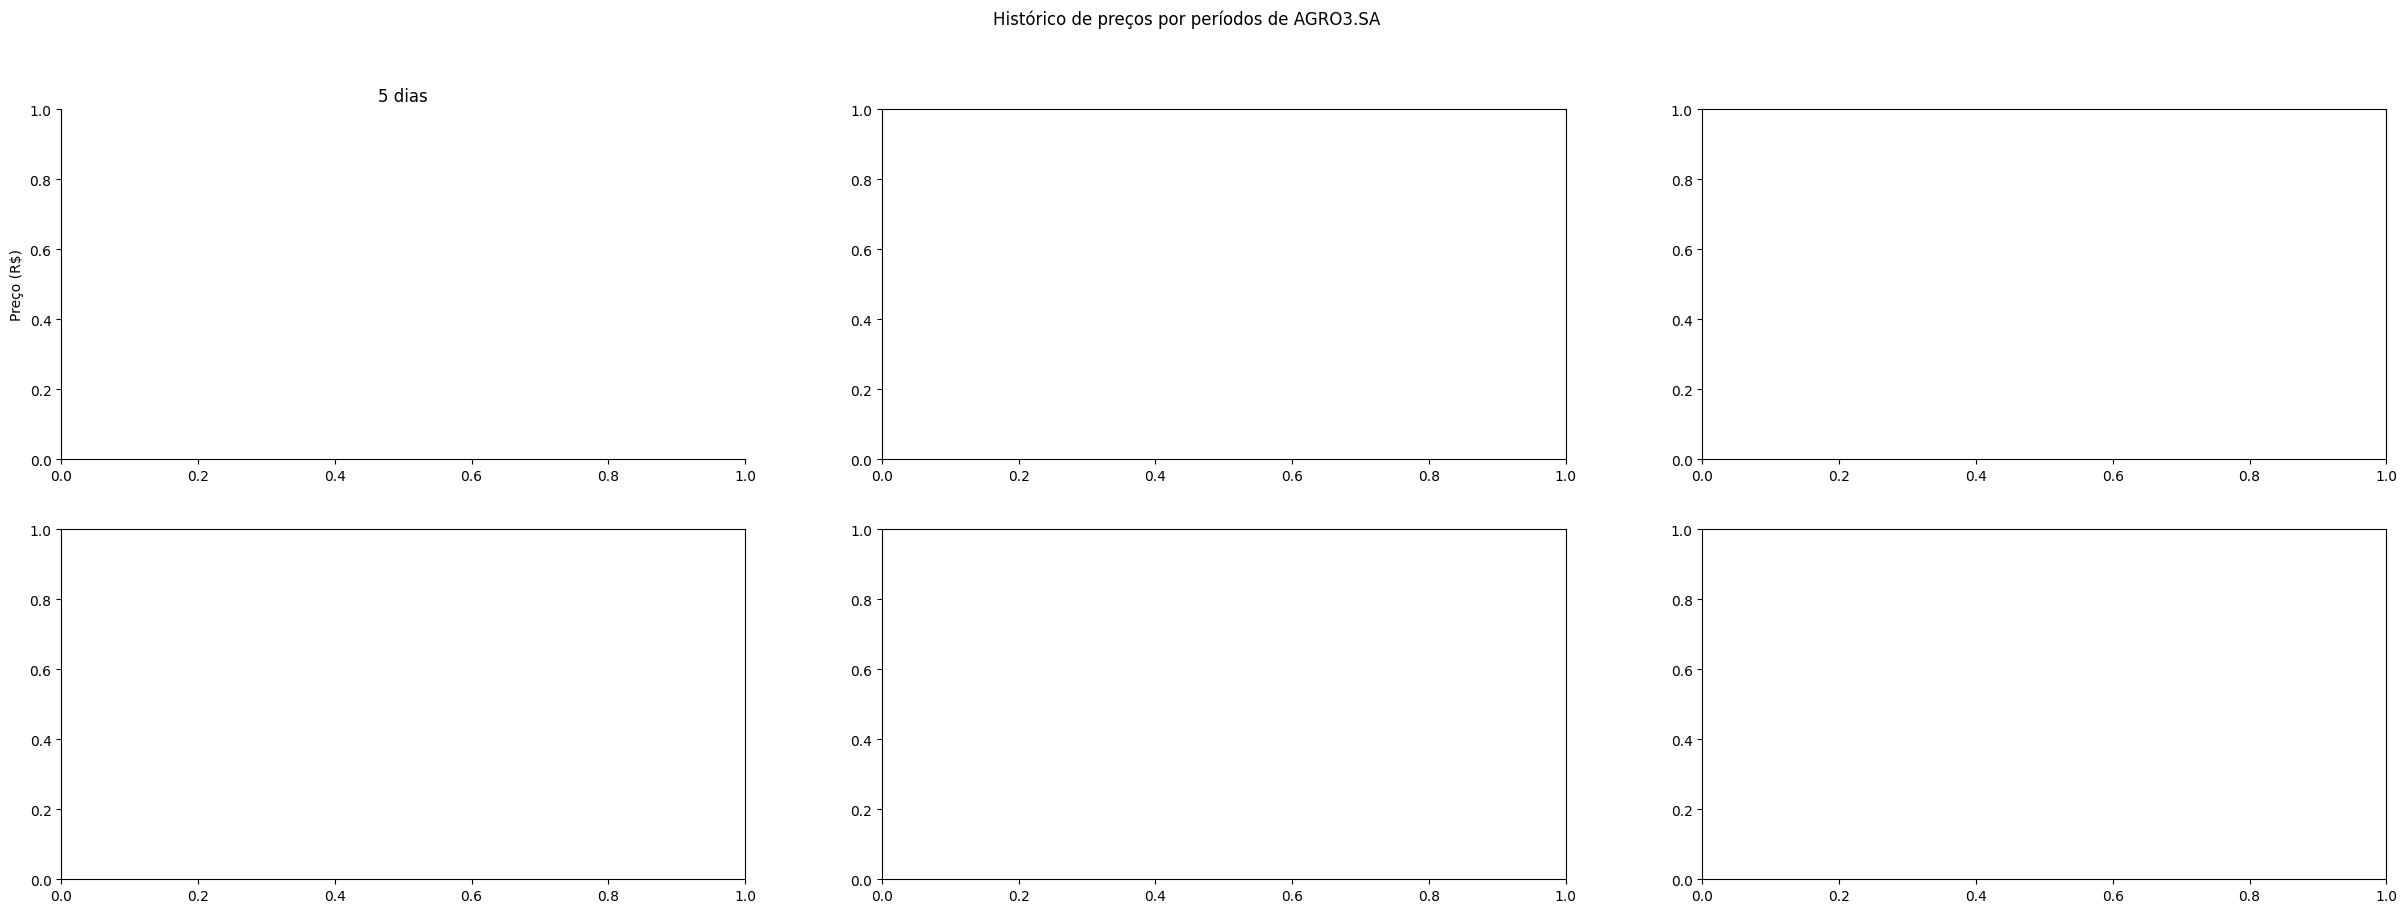

In [48]:
day5 = tk.history('5d')
m1 = tk.history('1mo')
m3 = tk.history('3mo')
m6 = tk.history('6mo')
y1 = tk.history('1y')
y5 = tk.history('5y')

dados = [day5['Close'], m1['Close'], m3['Close'], m6['Close'], y1['Close'], y5['Close']]

names = ['5 dias', '1 mês', '3 meses', '6 meses', '1 ano', '5 anos']

fig, vax = plt.subplots(2, 3)

fig.suptitle(f'Histórico de preços por períodos de {yahooTicker}')
fig.set_figwidth(30)
fig.set_figheight(10)

for ax, data, name in zip(vax.flat, dados, names):
    despine(ax)

    ax.set_title(name)
    ax.set_ylabel('Preço (R$)')
    df = data.to_frame().reset_index()

    target = df['Close']

    ax.plot(data)


plt.show()

## Histórico de Indicadores Fundamentalistas

Os gráficos à seguir tem a intenção de detalhar o histórico de alguns indicadores fundamentalistas referentes ao Ticker em questão. (P/L, DY, VPA, P/VP) 

In [ ]:
valores = [pd.DataFrame(indicadoresDf['P/L']['series']), pd.DataFrame(indicadoresDf['Dividend Yield']['series']),pd.DataFrame(indicadoresDf['VPA']['series']), pd.DataFrame(indicadoresDf['P/VP']['series'])]

indexes = ['P/L', 'Dividend Yield', 'VPA', 'P/VP']

fig, vax = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(18)

fig.suptitle(f'Indicadores Fundamentalistas {yahooTicker}', fontsize=24)

for ax, data, name in zip(vax.flat, valores, indexes):
    despine(ax)
    ax.set_title(f'{name}')
    ax.plot(data['year'], data['value'])

    for i in range(len(data)):
        ax.text(data['year'][i], round(data['value'][i], 2), f'{data["value"][i]:.2f}' , size=12)


plt.show()

posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


posx and posy should be finite values


<Figure size 5400x3000 with 4 Axes>

## Cálculo de Dívida Líquida / EBIT

Em quanto tempo, com o lucro corrente, a empresa paga suas dívidas?


In [ ]:
ebitHist = pd.DataFrame(indicadoresDf['Dívida Líquida/EBIT']['series'])

fig, ax = plt.subplots()

ax.plot(ebitHist['year'], ebitHist['value'])

for i in range(len(ebitHist)):
    ax.text(ebitHist['year'][i], round(ebitHist['value'][i], 2), f'{ebitHist["value"][i]:.2f}' , size=8)

despine(ax)

ax.set_title('Divida Líquida / EBIT')
fig.show()

<Figure size 1650x1050 with 1 Axes>

## Cálculo do valor pelo método de Graham

O método de Graham utiliza de dois indicadores fundamentalistas: $LPA$ e $VPA$, para realizar o cálculo do "Valor Justo" de uma ação, ou seja, o valor que ela deveria ter de acordo com seus indicadores fundamentalistas. O cálculo é realizado através da seguinte fórmula:

$$
\sqrt{22.5 * LPA * VPA}
$$

Além disso, é calculada também uma margem de segurança em relação ao preço ideal de uma ação, que é um decréscimo de 15-30% do valor ideal. O valor de margem de segurança é subjetivo, e deve variar de acordo com a empresa.

In [ ]:
graham = np.sqrt(22.5 * indicadoresDf['VPA']['currentValue'] * indicadoresDf['LPA']['currentValue'])

safetyMargin = graham - float(envVals['SAFETY']) * graham
safetyMargin20 = graham - 0.2 * graham

safetypercent = float(envVals['SAFETY']) * 100

In [ ]:

fig, ax= plt.subplots(1, 1, constrained_layout =True)

# Plotando valor de Graham atual vs COtação
ax.axhline(y=graham, color='green', linestyle='dashed', label=f'Graham: R${graham:.2f}')

ax.axhline(y=safetyMargin, color='red', linestyle='dashed', label=f'Margem de segurança ({safetypercent}%): R${safetyMargin:.2f}')

ax.axhline(y=safetyMargin20, color='orange', linestyle='dashed', label=f'Margem de segurança (20.0%): R${safetyMargin20:.2f}')

ax.plot(tickerDf['Close'], label='Preço de fechamento')

despine(ax)

fig.suptitle(f"Análise de Graham {yahooTicker}")

ax.legend()

<Figure size 1650x1050 with 1 Axes>